In [12]:
import numpy as np
import pandas as pd


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns

# Prediction
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import itertools

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier # Validation

# Data prepping
from sklearn.preprocessing import LabelEncoder

print("Libraries imported.")

Libraries imported.


In [13]:
data = pd.read_csv('/Users/mahaksharma/Downloads/globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')
print("Data loaded.")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data loaded.


In [14]:
data_columns = [
    
    'eventid', # Unique ID for a row. No analytic or predictive power, but used in some plotting functions.
    
    # ===== Spatio-Temporal Variables =====
    # The names of these variables speak for themselves;
    # where in time and space was the act of terrorism committed?
                'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
    # ===== Binary Variables (1 -> yes or 0 -> no) ===== 
                'extended', # Did the duration of the incident extend 24 hours?
                'vicinity', # Did the incident occur in the immediate vicinity of the city? Is 0 for IN city.
                'crit1', 'crit2', 'crit3', # The incident meets the criterion (1, 2, 3), described in the introduction.
                'doubtterr', # Is there doubt to wether the attack is an act of terrorism?
                'multiple', # Is this incident connected to other incident(s)? !! Consistently available since 1997 !!
                'success', # Has the attack reached its goal? Depends on type of attack.
                'suicide', # Did the perpetrator intend to escape alive?
                'claimed', # Was the attack claimed by an organised group?
                'property', # Is there evidence of property damage from the incident?
                'ishostkid', # Were there victims taken hostage or kidnapped?
    
    # ===== Continuous Variables =====
                'nkill', # Amount of confirmed kills.
                'nwound', # Amount of confirmed wounded.
    
    # ===== Categorical variables =====
                'country_txt', # Name of country.
                'region', # Region id.
                'region_txt', # Name of region.
                'attacktype1_txt', # Of what type was the attack? I.e. assassination, bombing or kidnapping.
                'targtype1_txt', # What target did the attack have? I.e. business, government or police.
                'natlty1_txt', # Nationality of the target.
                'weaptype1_txt', # What weapon was used?
    
    # ===== Descriptive Variables =====
                'target1', # Description of specific target, if applicable.
                'gname', # Name of the organized group, if applicable.
                'summary', # Summary of the attack.
    
]

In [15]:
data = data.loc[:, data_columns] # Only keep described columns.

# Random acts of violence and other outliers should not be part of the data.
# Thus, restrict the set the only attacks where the terrorism motive is certain.
data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]

# Weapontype column contains very long name for vehicle property -> shorten.
data.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

# Replace -9 (unknown) values with 0 (no). -9 values are much more likely to be false than true.
data.iloc[:,[6, 15, 16, 17]] = data.iloc[:,[6, 15, 16, 17]].replace(-9,0)

# Some values in the claimed category are 2 (should be 0 or 1).
# Assume these were input mistakes and set 2 to 1.
data.claimed.replace(2,1, inplace = True)

# Ensure consistent values and make everything lowercase.
data.target1 = data.target1.str.lower()
data.gname = data.gname.str.lower()
data.summary = data.summary.str.lower()    
data.target1 = data.target1.fillna('unknown').replace('unk','unknown')

# Some nwound and nkill are NaN. Replace them with median.
data.nkill = np.round(data.nkill.fillna(data.nkill.median())).astype(int) 
data.nwound = np.round(data.nwound.fillna(data.nwound.median())).astype(int) 

data['ncasualties'] = data['nkill'] + data['nwound']
data['has_casualties'] = data['ncasualties'].apply(lambda x: 0 if x == 0 else 1)

print("Data cleaned and prepared.")

Data cleaned and prepared.


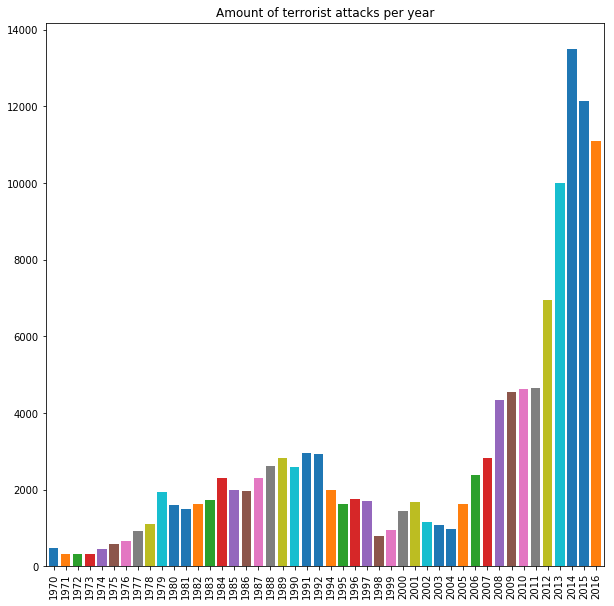

In [16]:
barplot = pd.value_counts(data['iyear'])\
.sort_index()\
.plot\
.bar(width=0.8, figsize=(10, 10), title="Amount of terrorist attacks per year")


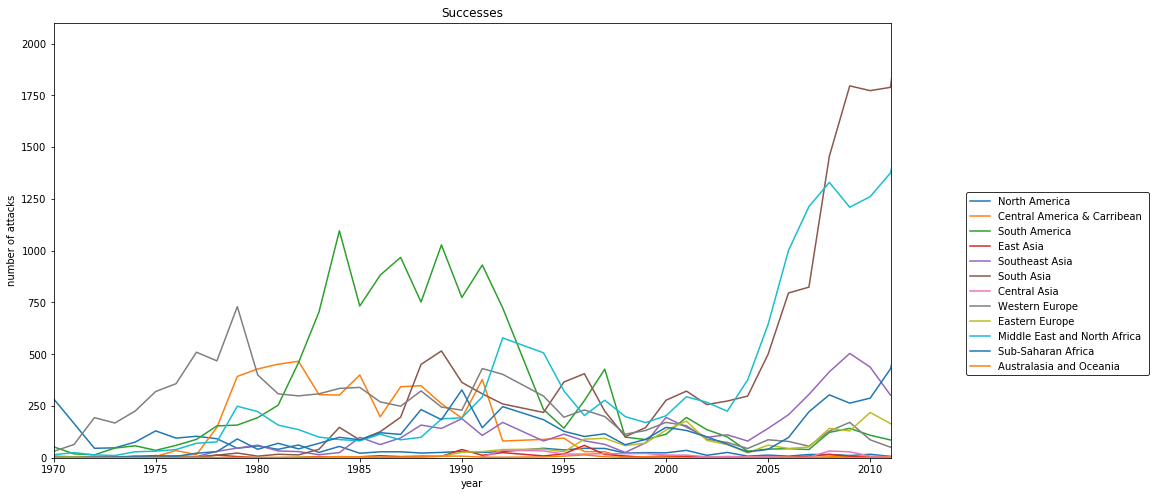

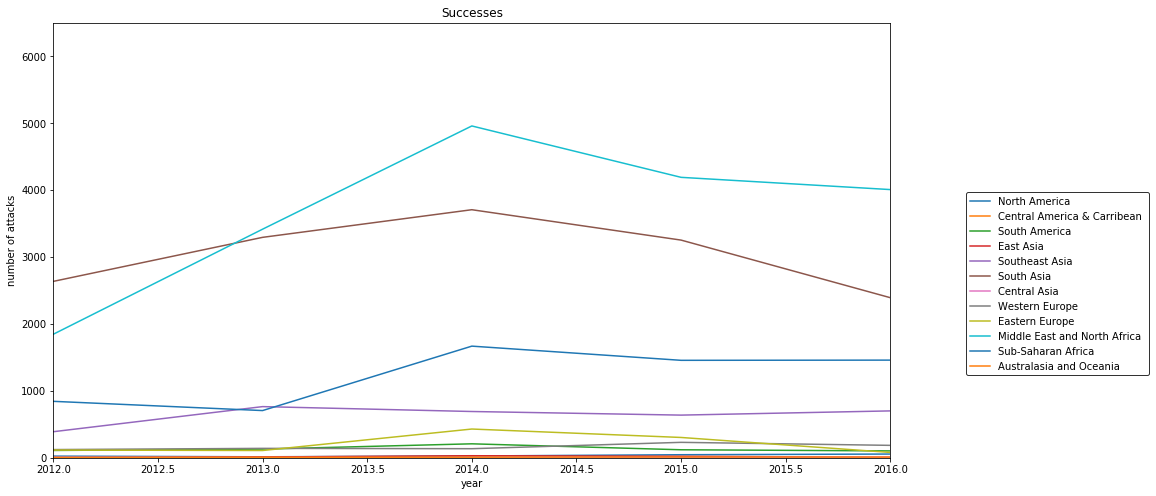

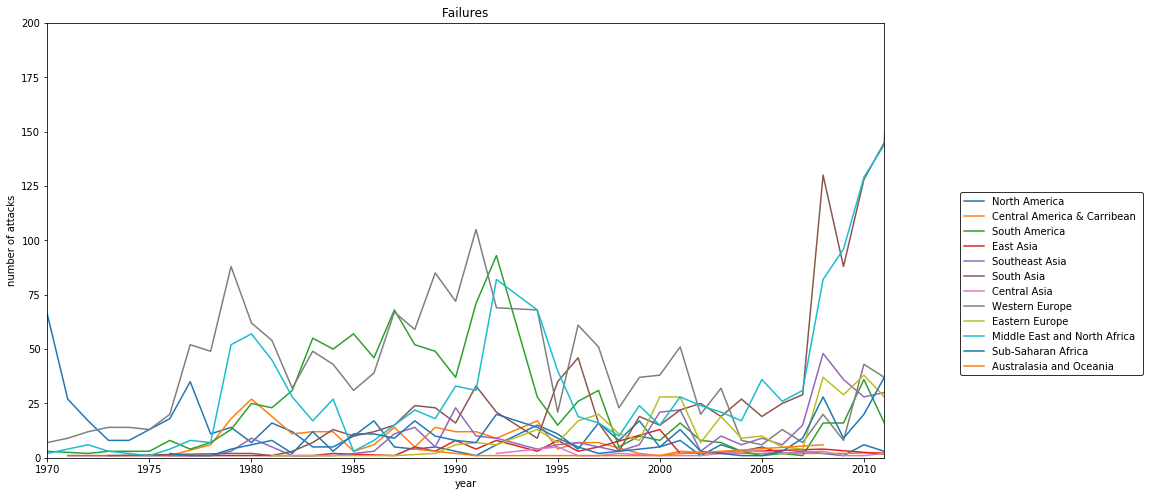

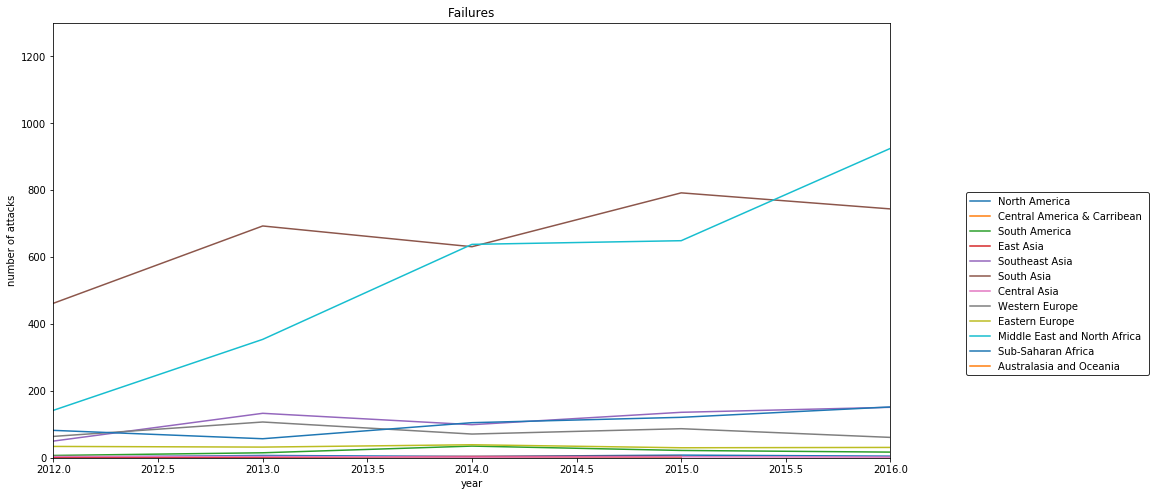

In [17]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = data[(data.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2011, 0, 2100)
multi_graph('Successes',success_list, 2012, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2011, 0, 200)
multi_graph('Failures',failure_list, 2012, 2016, 0, 1300)

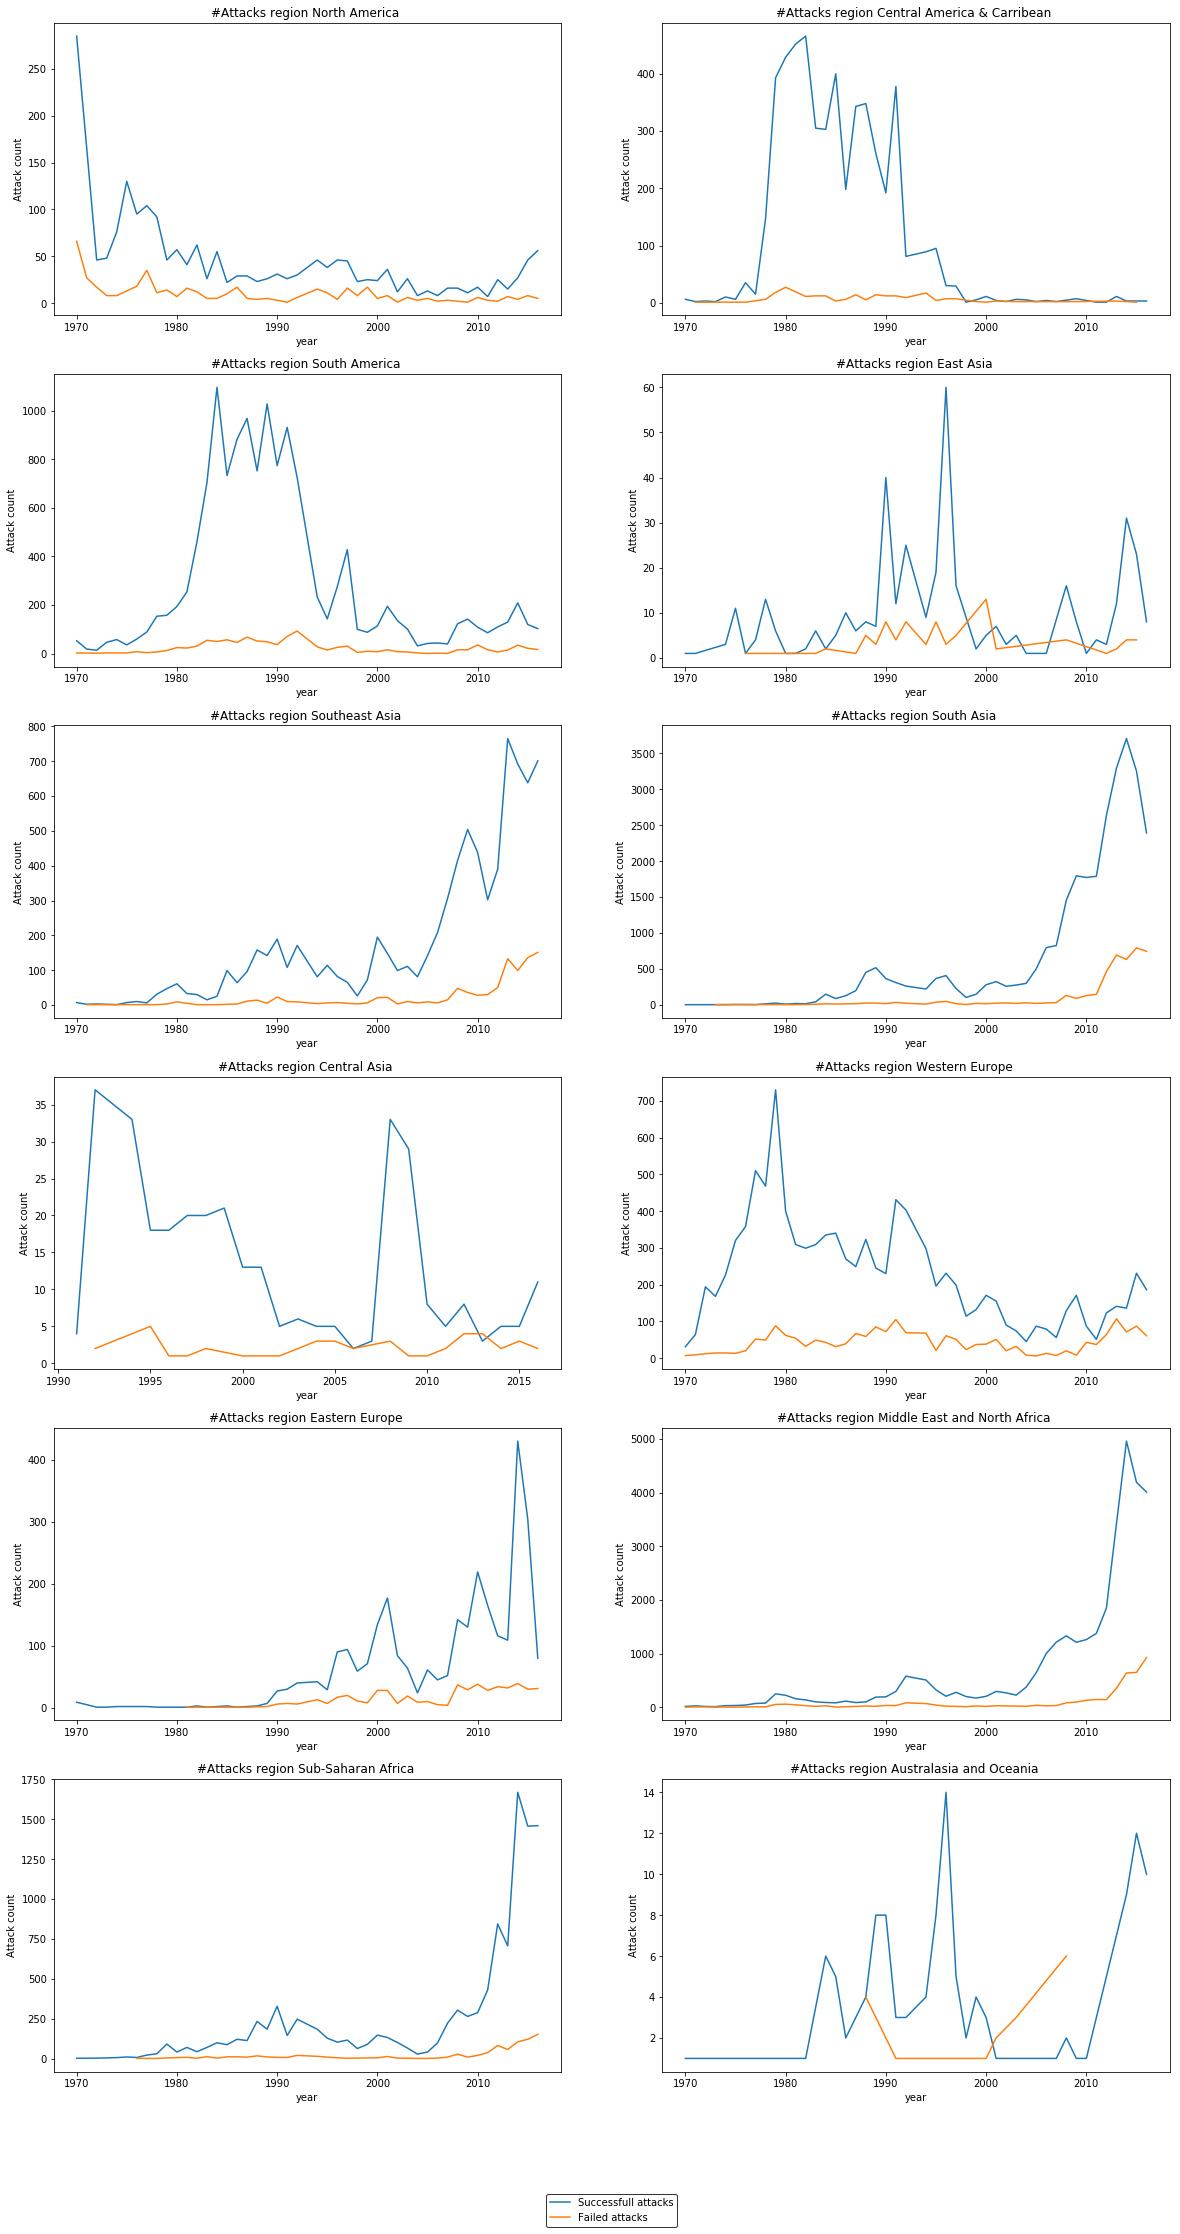

In [ ]:
def generate_graph(by_region_list):
    fig = plt.figure(figsize=(20,70))
    i = 1
    
    for element in by_region_list:
        ax1 = fig.add_subplot(11,2,i)
        ax1.set(title = '#Attacks region %s ' % region_dictionary[element[2]],
                ylabel = 'Attack count', xlabel = 'year')

        #entering data
        ax1.plot(element[0].index, element[0].eventid, label = 'Successfull attacks' )
        ax1.plot(element[1].index, element[1].eventid, label = 'Failed attacks' )
        
        i+=1
    
    #add legend
    ax1.legend(loc = 'upper center', frameon = True, edgecolor = 'black', bbox_to_anchor =(-0.1,-0.4))
    plt.show()  


def by_region():
        for region_number in region_dictionary:
            region_data = data[(data.region == region_number)] #for each region group data by year
            region_grouped_success = region_data[(region_data.success == 1)].groupby('iyear').count() #filter on success and group by year
            region_grouped_failure = region_data[(region_data.success == 0)].groupby('iyear').count() #filter on failure and group by year
            
            by_region_list.append([region_grouped_success, region_grouped_failure, region_number])
        
        #create line plot for region grouped by year
        generate_graph(by_region_list)

by_region_list = []
by_region()

In [ ]:
orange_palette = ((3, 0, '#FBBC00', '1 - 20'), (4, 20, '#FDA600', '21 - 50'), (5, 50, '#EE8904', '51 - 100'), \
                  (7, 100, '#ED9001', '101 - 250'), (9, 250, '#ED6210', '251 - 600'), \
                  (11, 600, '#DE6D0A', '601 - 1000'), (13, 1000, '#D8510F', '1001 - 2000'), \
                  (15, 2000, '#D23711', '2001 - 4000'), (18, 4000, '#F61119', '4001 - 7500'), \
                  (30, 7500, '#9C200A', '7501 - ∞')) #marker size, count size, color

plt.figure(figsize=(15,15))
# Rounds the long- and latitude to a number withouth decimals, groups them on long- and latitude and counts the amount of attacks.
df_coords = data.round({'longitude':0, 'latitude':0}).groupby(["longitude", "latitude"]).size().to_frame(name = 'count').reset_index()
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.shadedrelief()
    
def plot_points(marker_size, count_size, colour, label_count):
    x, y = m(list(df_coords.longitude[df_coords['count'] >= count_size].astype("float")),\
                (list(df_coords.latitude[df_coords['count'] >= count_size].astype("float"))))
    points = m.plot(x, y, "o", markersize = marker_size, color = colour, label = label_count, alpha = .5)

for p in orange_palette:
    plot_points(p[0], p[1], p[2], p[3]) 
    
plt.title("Amount of terrorist attacks per rounded coordinates", fontsize=24)
plt.legend(title= 'Colour per counted attack', loc ='lower left', prop= {'size':11})
plt.show()

In [ ]:
sns.jointplot(x='longitude', y='latitude', data=df_coords, kind="hex", color="#4CB391", size=15, stat_func=None, edgecolor="#EAEAF2", linewidth=.2)
plt.title('Amount of terrorist attacks per rounded coordinates')

In [ ]:
plt.figure(figsize=(9,7))
ax = sns.countplot(y="attacktype1_txt", data=data)
ax.set_xlabel("Amount of attacks")
ax.set_ylabel("Attack type")

In [ ]:

data_w = pd.read_csv('/Users/mahaksharma/Downloads/terrorist_weather_jan2012_dec_2016.csv', encoding='ISO-8859-1')

In [ ]:

data_w.head()

In [ ]:
# Define X and y.
X = data_w[['t2m', 'tcc', 'vidgf', 'sp', 'v10']].fillna(0) # Features
y = data_w['has_casualties'].fillna(0) # Target

X.shape, y.shape

In [ ]:

y.value_counts()

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = svm.SVC()


%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

In [ ]:
np.mean(y_pred == y_test)

In [ ]:

model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

In [ ]:
feature_cols = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
                'extended',
                'vicinity',
                'doubtterr',
                'multiple',
                'success',
                'suicide',
                'claimed',
                'property',
                'ishostkid',
    
                'country_txt',
                'region',
                'attacktype1_txt',
                'targtype1_txt',
                'weaptype1_txt',
]


target_col = 'has_casualties'

lb = LabelEncoder()
data['country_txt'] = lb.fit_transform(data['country_txt'])
data['attacktype1_txt'] = lb.fit_transform(data['attacktype1_txt'])
data['targtype1_txt'] = lb.fit_transform(data['targtype1_txt'])
data['weaptype1_txt'] = lb.fit_transform(data['weaptype1_txt'])

X = data[feature_cols].fillna(0)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:

forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
fnames = [feature_cols[i] for i in indices]


plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), fnames, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
feature_cols = ['longitude', 'targtype1_txt', 'latitude', 'attacktype1_txt', 'success', 'property', 'country_txt', 'weaptype1_txt', 'region']

X = data[feature_cols].fillna(0) # Assign chosen features to X.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
model = RandomForestClassifier(n_estimators=20)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()